In [1]:
import psycopg2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Caricamento e Preprocessing
# -------------------------------

# Parametri di connessione
host = "localhost"
port = "5432"
dbname = "DataScience"
user = "postgres"
password = "2430"

# Connessione a PostgreSQL
conn = psycopg2.connect(
    host=host,
    port=port,
    dbname=dbname,
    user=user,
    password=password
)

# Query sulla vista
query = "SELECT * FROM public.vew_mts_provsensori"

# Caricare i dati in un DataFrame di Pandas
df = pd.read_sql_query(query, conn)

# Chiudere la connessione
conn.close()

# Visualizzare i dati
print("Primi dati caricati:")
print(df.head())


Primi dati caricati:
  provincia      giorno  total_transiti  total_trleggeri  total_trpesanti  \
0        MO  2019-01-01          143577           142750              822   
1        BO  2019-01-01          261563           260314             1242   
2        RN  2019-01-01            8264             8228               36   
3        PR  2019-01-01            4602             4588               14   
4        PC  2019-01-01            7138             7093               45   

   total_trnonclassificati  total_trdiurno  total_trnotturno  total_trferiali  \
0                       50           86068             57509                0   
1                       70          158381            103182                0   
2                        0            5210              3054                0   
3                        0            2712              1890                0   
4                        0            4286              2852                0   

   total_trfestivi  ngiornose

C:\Users\matte\AppData\Local\Temp\ipykernel_82384\605741899.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [2]:
# Conversione della colonna 'giorno' in formato datetime
df['giorno'] = pd.to_datetime(df['giorno'])

# Aggiungere features: giorno della settimana e mese
df['giorno_della_settimana'] = df['giorno'].dt.weekday
df['mese'] = df['giorno'].dt.month

# Creare il target: traffico totale per il giorno (assunto essere nella colonna 'total_transiti')
df['target'] = df['total_transiti']

# Creare variabili per i giorni precedenti
df['prev_transiti'] = df['total_transiti'].shift(1)
df['prev_trleggeri'] = df['total_trleggeri'].shift(1)
df['prev_trpesanti'] = df['total_trpesanti'].shift(1)
df['prev_trnonclassificati'] = df['total_trnonclassificati'].shift(1)

# Rimuovere le righe con NaN (es. la prima riga, dovuta allo shift)
df = df.dropna()
# Applicare One-Hot Encoding per la colonna 'sensori' (aboveground, underground)
df = pd.get_dummies(df, columns=['sensori'], prefix='sensori')

# Visualizzare le colonne per verificare l'encoding
print("\nColonne dopo l'encoding dei sensori:")
print(df.columns.tolist())


Colonne dopo l'encoding dei sensori:
['provincia', 'giorno', 'total_transiti', 'total_trleggeri', 'total_trpesanti', 'total_trnonclassificati', 'total_trdiurno', 'total_trnotturno', 'total_trferiali', 'total_trfestivi', 'ngiornosettimana', 'giorno_della_settimana', 'mese', 'target', 'prev_transiti', 'prev_trleggeri', 'prev_trpesanti', 'prev_trnonclassificati', 'sensori_Aboveground', 'sensori_Underground']


In [3]:
# -------------------------------
# 2. Esperimenti di Modellazione
# -------------------------------

# Definiamo le feature di base (senza le informazioni sui sensori)
base_feature_cols = ['prev_transiti', 'prev_trleggeri', 'prev_trpesanti', 'prev_trnonclassificati', 
                     'giorno_della_settimana', 'mese']

# Modelli Indipendenti per ciascun tipo di sensore
# Creiamo dataset separati per Aboveground e Underground
df_above = df[df['sensori_Aboveground'] == 1].copy()
df_under = df[df['sensori_Underground'] == 1].copy()

print(f"\nNumero di record per Aboveground: {len(df_above)}")
print(f"Numero di record per Underground: {len(df_under)}")


Numero di record per Aboveground: 2869
Numero di record per Underground: 3284


In [4]:
# Modello per sensori Aboveground
X_above = df_above[base_feature_cols]
y_above = df_above['target']

X_train_above, X_test_above, y_train_above, y_test_above = train_test_split(X_above, y_above, test_size=0.2, shuffle=False)

model_above = RandomForestRegressor(n_estimators=100, random_state=42)
model_above.fit(X_train_above, y_train_above)
y_pred_above = model_above.predict(X_test_above)
mae_above = mean_absolute_error(y_test_above, y_pred_above)
print(f"\nMAE per sensori Aboveground: {mae_above}")


MAE per sensori Aboveground: 12732.284146341462


In [5]:
# Modello per sensori Underground
X_under = df_under[base_feature_cols]
y_under = df_under['target']

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2, shuffle=False)

model_under = RandomForestRegressor(n_estimators=100, random_state=42)
model_under.fit(X_train_under, y_train_under)
y_pred_under = model_under.predict(X_test_under)
mae_under = mean_absolute_error(y_test_under, y_pred_under)
print(f"MAE per sensori Underground: {mae_under}")

MAE per sensori Underground: 108228.82928462708


In [6]:
# Modello Misto che usa le informazioni sui sensori

# Includiamo le feature relative ai sensori
mixed_feature_cols = base_feature_cols + ['sensori_Aboveground', 'sensori_Underground']
X_mixed = df[mixed_feature_cols]
y_mixed = df['target']

X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = train_test_split(X_mixed, y_mixed, test_size=0.2, shuffle=False)

model_mixed = RandomForestRegressor(n_estimators=100, random_state=42)
model_mixed.fit(X_train_mixed, y_train_mixed)
y_pred_mixed = model_mixed.predict(X_test_mixed)
mae_mixed = mean_absolute_error(y_test_mixed, y_pred_mixed)
print(f"\nMAE per il modello misto (entrambi i sensori): {mae_mixed}")


MAE per il modello misto (entrambi i sensori): 63507.07363119415



Importanza delle feature nel modello misto:
                  Feature  Importance
7     sensori_Underground    0.306048
6     sensori_Aboveground    0.294086
2          prev_trpesanti    0.115777
1          prev_trleggeri    0.078710
0           prev_transiti    0.072884
3  prev_trnonclassificati    0.045665
5                    mese    0.045287
4  giorno_della_settimana    0.041544


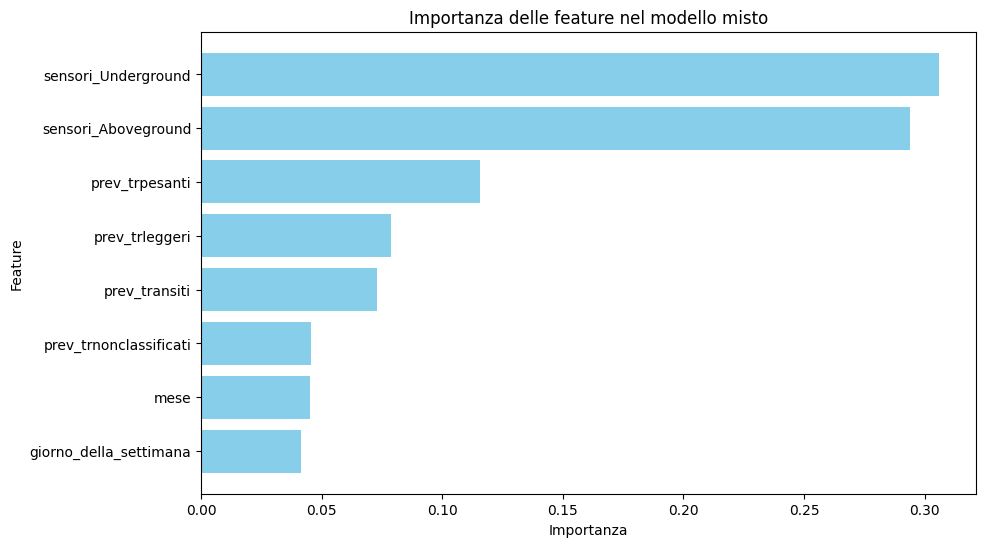

In [7]:
# Analisi dell'importanza delle feature nel modello misto
importances = model_mixed.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': mixed_feature_cols, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nImportanza delle feature nel modello misto:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importanza")
plt.ylabel("Feature")
plt.title("Importanza delle feature nel modello misto")
plt.gca().invert_yaxis()
plt.show()

In [8]:
print(f"\nConfronto dei MAE:")
print(f"MAE Aboveground: {mae_above}")
print(f"MAE Underground: {mae_under}")
print(f"MAE Misto (entrambi): {mae_mixed}")


Confronto dei MAE:
MAE Aboveground: 12732.284146341462
MAE Underground: 108228.82928462708
MAE Misto (entrambi): 63507.07363119415
